# M2608.001300 기계학습 기초 및 전기정보 응용<br> Assignment #4 Part 2: Recurrent Neural Networks (RNNs)

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Nohil Park, May 2021.

**For understanding of this work, please carefully look at given PPT file.**

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **PyTorch**. <br>

In this notebook, you will learn how to train a Recurrent Neural Network (RNN) for sequential modeling. Specifically, you will build a character-level RNN to generate names from different languages. <br> 
You need to follow the instructions to **complete 4 TODO sections and explain them if needed.**

You will see:
- how to implement a character-level RNN in PyTorch;
- train the network; and
- sampling sequences from the network.


**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results. 


### Some helpful tutorials and references for assignment #4:
- [1] Pytorch official documentation. [[link]](https://pytorch.org/docs/stable/index.html)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] https://ratsgo.github.io/machine%20learning/2017/03/18/HMMs/
- [4] https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/

In [2]:
%matplotlib inline

Preparing the Data
==================

Note:
   Extract the ``rnn_data.zip`` to the current directory.

The dataset has a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




Execute the following 2 cells if you are using Google Colab, otherwise just skip. Rename the statement after `cd` with your current directory (e.g. `cd /content/drive/your/current/directory/`). Refer to Assignment1's data loading sceme if you have troubles.

In [ ]:
# Execute this and below cell if you are using Google Colab, otherwise just skip.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded rnn_data.zip '
        'from eTL and extract it to the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 [u'Japanese', u'Irish', u'English', u'Italian', u'Greek', u'Czech', u'French', u'German', u'Dutch', u'Chinese', u'Russian', u'Scottish', u'Arabic', u'Portuguese', u'Korean', u'Vietnamese', u'Spanish', u'Polish']
O'Neal


Problem 1. Creating the Network
====================

**TODO 1**: Instead of using ``torch.nn.RNN``, build your own RNN network.

RNN architecture in order:
- ``i2h`` : a linear layer for the hiddent
- ``i2o`` : a linear layer for the output
- ``o2o`` : a linear layer after combining hidden and output
- ``dropout`` : randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
- ``softmax`` : LogSoftmax for the final output

Category tensor is a one-hot vector just like the letter input and it is concatenated with the input and hidden. Output is interpreted as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.





In [4]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, category, input, hidden):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        """
        forward pass
        Input:
            category: 1 x category_num[18]
            input: 1 x n_letters[56]
            hidden_state: 1 x hidden_size
        Output:
            next_letter: 1 x n_letters
            next hidden_state = 1 x hidden_size
        """
        concatenated_input = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(concatenated_input)
        output = self.i2o(concatenated_input)
        concatenated_output = torch.cat((hidden, output), 1)
        output = self.o2o(concatenated_output)
        
        output = self.dropout(output)
        output = self.softmax(output)
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [5]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

The category tensor is a `one-hot
tensor`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [6]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [7]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [8]:
category, line = randomTrainingPair()
category_tensor = categoryTensor(category)
input_line_tensor = inputTensor(line)
target_line_tensor = targetTensor(line)

In [9]:
category, line

(u'Scottish', u'Wright')

Problem 2. Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.

**TODO 2**: Define a loss function, learning rate and hidden size for RNN training.




In [10]:
# Define a loss function, learning rate, hidden size
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################

def criterion(logprob, answer): 
    out = torch.zeros_like(answer, dtype=torch.float)
    for i in range(len(answer)):
        out[i] = logprob[i][answer[i]]
    return -out.sum()
#criterion = nn.NLLLoss()
    
n_hidden = 128
learning_rate = 0.0003

##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [11]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [12]:
rnn = RNN(n_letters, n_hidden, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
torch.save(rnn.state_dict(), 'RNN.pth')

0m 51s (5000 5%) 2.8455
1m 40s (10000 10%) 2.3916
2m 30s (15000 15%) 2.9379
3m 19s (20000 20%) 3.0495
4m 8s (25000 25%) 2.6020
4m 58s (30000 30%) 2.4123
5m 47s (35000 35%) 2.6315
6m 36s (40000 40%) 1.7306
7m 26s (45000 45%) 2.4982
8m 15s (50000 50%) 2.7332
9m 7s (55000 55%) 2.7326
9m 58s (60000 60%) 2.1003
10m 51s (65000 65%) 2.1413
11m 42s (70000 70%) 2.3554
12m 34s (75000 75%) 2.7744
13m 25s (80000 80%) 2.4372
14m 16s (85000 85%) 2.9409
15m 4s (90000 90%) 2.4490
15m 54s (95000 95%) 2.3063
16m 42s (100000 100%) 2.0480


Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




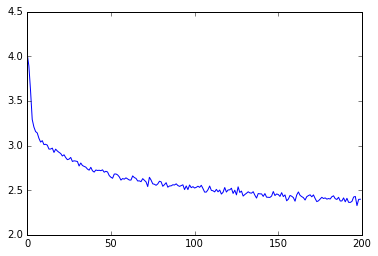

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Problem 3. Sampling from the Network
====================

**TODO 3**: To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [17]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    with torch.no_grad():
        category_one_hot = categoryTensor(category)
        letter_one_hot = inputTensor(start_letter)[0]
        hidden = rnn.initHidden()

        output_chars = list()
        output_chars.append(start_letter)

        for _ in range(max_length):
            output, hidden = rnn(category_one_hot, letter_one_hot, hidden)
            _, max_idx = output.topk(1)
            # EOF checking
            if max_idx == n_letters - 1:
                break
            next_letter = all_letters[max_idx]
            output_chars.append(next_letter)
            letter_one_hot = inputTensor(next_letter)[0]

        output_name = ''.join(output_chars)
    
    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

**TODO 4**: Sample 12 different names from 4 languages (i.e. 3 names per language). Use the ``samples`` function defined above.

In [22]:
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
samples("French", 'RDG')
samples("English", 'ADE')
samples("Chinese", "ZWE")
samples("Russian", "SIA")
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

Ranten
Darer
Garer
Allen
Dangere
Eanton
Zan
Wang
Eongo
Santon
Ianovev
Alanov
